In [ ]:
import itertools as it
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.linear_model import Lasso
from abc import ABC, abstractmethod
from scipy import stats
import warnings
import seaborn as sns

The scenario being modeled here involves the impact of combinations of drugs on a given output metric. We assume that individual drugs inmpact the output, and that there are higher-order effects of drug combinations on the output as well, but that those effects decay as the combinations increase (i.e., 4th-order effects are less likely/impactful than 2nd-order effects).

The goal is to be able to predict the entire combination space with as few measurements as possible. 

I've implemented an adaptive learning scheme, which takes a model and a current set of data and makes a decision about which sample in the sample space to measure next. Additionally, I've implemented classes to simulate using this scheme, and also a scheme that randomly chooses the next sample to measure, for comparison.

# Generate Test Data

In [2]:
drugs = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# generate all possible combinations of drugs
all_combos = []
for combo_size in range(1, len(drugs) + 1):
    for combo in it.combinations(drugs, combo_size):
        all_combos.append(''.join(combo))
        
# make design matrix of all combinations
condition_mat = pd.DataFrame(0, index = all_combos, columns = all_combos)
for combo in all_combos:
    sub_combos = []
    for sub_size in range(1, len(combo) + 1):
        for sub_combo in it.combinations(combo, sub_size):
            sub_combos.append(''.join(sub_combo))
    condition_mat.loc[combo, sub_combos] = 1

In [3]:
base_effect = 3
error = 0.25
rng = np.random.default_rng()

# generate effect for each drug combination
# possible effect size decays with order of combination
effects = [rng.normal(scale = base_effect * 10**-len(combo)) 
           for combo in all_combos]
# base value for each combination (sum of sub-combo effects)
y = pd.Series(np.matmul(np.array(condition_mat), np.array(effects)))
y.index = condition_mat.index
# add error
y += rng.normal(scale = error, size = len(y))

# Class

In [4]:
class MeasurementIterator (ABC):
    
    '''
    Abstract class for learning model iterators.
    Iterates through sample space, "measuring" a new sample each time.
    _next_step function decides which sample to measure next.
    '''
    
    def __init__(self, x, y, starting_fraction, model):
        self.full_x = x
        self.full_y = y
        self.model = model

        train_test = ms.train_test_split(x.index,
                                         train_size = starting_fraction)
        self.measured = list(train_test[0])
        self.unmeasured = list(train_test[1])

    def assess_model(self):
        # assess predictive power of model given currrently measured samples        
        self.model.fit(self.full_x.loc[self.measured, :], 
                       self.full_y[self.measured])
        predictions = self.model.predict(self.full_x.loc[self.unmeasured, :])
        return stats.pearsonr(predictions, y[self.unmeasured])[0]
    
        
    def n_measured(self):
        return len(self.measured)
    
    def __iter__(self):
        return self
        
    def __next__(self):
        if len(self.unmeasured) == 0:
            raise StopIteration
            
        next_step = self._next_step()    
        
        self.measured.append(next_step)
        self.unmeasured.remove(next_step)

        return next_step
    
    @abstractmethod
    def _next_step(self):
        pass

In [5]:
class MeasuringModelSimulator:
    
    '''
    Class for simulating a model in which measurements are taken over time,
    increasing the size of the data the model is trained on.
    The measurer is a MeasurementIterator, which determines which samples
    to measure as it is iterated over.
    '''
    
    def __init__(self, x, y, model, MeasurerClass):
        self.x = x
        self.y = y
        self.model = model
        self.MeasurerClass = MeasurerClass
    
    def __iter__(self):
        start_fraction = .25
        return self.MeasurerClass(self.x, self.y, start_fraction, self.model)
    
    def simulate (self, start_point = None, stop_point = None):
        # start fraction is passed to train_test_split
        # determines how much of the data starts as "measured"
        if start_point is None:
            start_fraction = .25
        else:
            start_fraction = start_point / len(self.y)
        if stop_point is None:
            stop_point = len(self.y) - 5
                        
        measurer = self.MeasurerClass(self.x, self.y,
                                      start_fraction, self.model)
        n_measureds = []
        scores = []
        for step in measurer:
            n_measureds.append(measurer.n_measured())
            scores.append(measurer.assess_model())
            
            if measurer.n_measured() >= stop_point:
                break

        return (pd.DataFrame({'n': n_measureds, 'score': scores}))
        

In [6]:
class AdaptiveIterator (MeasurementIterator):
    
    '''
    Chooses new sample to measure using an adaptive learning scheme.
    This scheme prioritizes samples with the highest uncertainity in the model,
    to predict the whole samples space as quickly as possible.
    '''
    
    def __init__(self, x, y, starting_fraction, model):
        super().__init__(x, y, starting_fraction, model)

    def _next_step(self):
        # split samples into folds
        kfold = ms.KFold(5, shuffle = True)
        folds = kfold.split(self.full_x.loc[self.measured, :])
        predictions = []
        for f in folds:
            # use fold to predict unmeasured
            self.model.fit(self.full_x.iloc[f[0]], self.full_y[f[0]])
            prediction = self.model.predict(self.full_x.loc[self.unmeasured, :])
            predictions.append(prediction)
        predictions = np.array(predictions)

        # next step has highest variance among fold predictions
        variances = np.var(predictions, axis = 0)
        next_step = self.unmeasured[np.argmax(variances)]

        return next_step


In [7]:
class RandomIterator (MeasurementIterator):
    
    '''
    Chooses next sample to measure randomly.
    '''
    
    def __init__(self, x, y, starting_fraction, model):
        super().__init__(x, y, starting_fraction, model)
        self.rng = np.random.default_rng()

    def _next_step(self):
        next_step = self.rng.choice(self.unmeasured)
        return next_step

# Tests

Because we expect that number of drugs/combinations that have actual effects is small, we can use LASSO regression, which minimizes the number of non-zero coefficients. We use scikit-learn `GridSearchCV` class to try out a number of `alpha` parameter in the LASSO model. 

In [8]:
warnings.filterwarnings('ignore', message = 'Objective did not converge')
params = {"alpha": [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 3, 5, 7, 10, 15]}
lasso_regressor = ms.GridSearchCV(Lasso(), params, 
                                  scoring = 'neg_mean_squared_error',
                                  cv=5)

## Simulate

In [9]:
# number of simulations to run
n_tests = 5

In [10]:
ad_simulator = MeasuringModelSimulator(condition_mat, y, 
                                       lasso_regressor, AdaptiveIterator)
ad_runs = [ad_simulator.simulate() for i in range(n_tests)]
ad_runs = pd.concat(ad_runs, keys = range(n_tests), names = ['run'])

In [11]:
rand_simulator = MeasuringModelSimulator(condition_mat, y, 
                                         lasso_regressor, RandomIterator)
rand_runs = [rand_simulator.simulate() for i in range(n_tests)]
rand_runs = pd.concat(rand_runs, keys = range(n_tests), names = ['run'])

## Plot

In [12]:
combined_res = pd.concat([ad_runs, rand_runs], 
                    keys = ['adaptive', 'random'], 
                    names = ['method'])
combined_res = combined_res.reset_index(['run', 'method'])

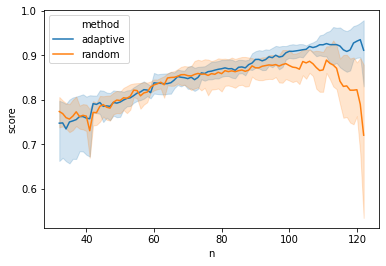

In [15]:
sns.lineplot(data = combined_res, x = 'n', y = 'score', hue = 'method')